## Dataset Checks

We need to see before moving on from our datasets whetehr or not they are truly independent from one another, usign different patients as to avoid repitition and redundancy and thus overfitting.

We will first start by importing the relevant libraries:

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
n_job = 6

As an easy way to trust how connected two datasets are, we can first try to compare the metadata from both datasets, we observe:

NOTE: we made the data in table fashion to be able to easily compare results from both easily.

In [21]:
import pandas as pd

# Create a comparison dictionary
metadata_comparison = {
    "Aspect": [
        "Donated",
        "Subjects",
        "Recordings",
        "Samples per subject",
        "Recording source",
        "Main goal",
        "Features",
        "File structure",
        "Identifier",
        "Paper / DOI"
    ],
    "Oxford PD Dataset (2008)": [
        "2008-06-25",
        "31 total (23 PD, 8 healthy)",
        "195 total voice samples",
        "~6 per person",
        "Oxford (UK)",
        "Classify PD vs healthy via sustained vowel /a/",
        "22 acoustic measures (MDVP jitter/shimmer etc.)",
        "Single CSV (195 rows x 24 cols)",
        "name (string) --> person ID",
        "Max Little et al., IEEE TBME (2008), DOI 10.24432/C59C74"
    ],
    "Istanbul PD Dataset (2014)": [
        "2014-06-11",
        "40 total (20 PD, 20 healthy)",
        "1040 total voice samples",
        "26 per person",
        "Cerrahpaşa Faculty of Medicine, Istanbul University (Turkiye)",
        "Classify & regress PD severity using multiple speech types (vowel, words, sentences)",
        "~26 acoustic measures (extended jitter/shimmer + pitch stats)",
        "Split into train/test folders; each subject has multiple utterances",
        "Subject_id (integer)",
        "Sakar et al., IEEE JBHI (2019), DOI 10.24432/CSNC8M"
    ]
}

# Convert to DataFrame and print neatly
df_meta = pd.DataFrame(metadata_comparison)
print(df_meta.to_string(index=False))


             Aspect                                 Oxford PD Dataset (2008)                                                           Istanbul PD Dataset (2014)
            Donated                                               2008-06-25                                                                           2014-06-11
           Subjects                              31 total (23 PD, 8 healthy)                                                         40 total (20 PD, 20 healthy)
         Recordings                                  195 total voice samples                                                             1040 total voice samples
Samples per subject                                            ~6 per person                                                                        26 per person
   Recording source                                              Oxford (UK)                        Cerrahpaşa Faculty of Medicine, Istanbul University (Turkiye)
          Main goal         

We observe, the difference in location, total patients, date, and nature of collection of the datasets (a British dataset vs Turkish dataset) makes it unlikely for collisions between the 2 datasets to exist. 

Regardless, we will try other tests to guarantee that indeed no overlap does exist.

______________________________________________________________________________________________________________________________________________________

## Tests For Overlap:

We will now extract the features from each dataset, with the "test_data.txt" and "train_data.txt" having to be extracted manually due to the original txt file not including any row for names. As for the "parkinsons.data", we can extract that directly using pd. 

We will be merging both train and test to one dataset as they have the same features, thus no point to keep theem seperate here.

We will only do for 2 datasets to test the feasability of doing this on more datasets later, we will begin with 2 and if we see promising results we will expand to more.


In [22]:

# Define column names
columns = [
    "Subject_id",
    # Jitter features
    "Jitter_local", "Jitter_local_absolute", "Jitter_rap", "Jitter_ppq5", "Jitter_ddp",
    # Shimmer features
    "Shimmer_local", "Shimmer_local_dB", "Shimmer_apq3", "Shimmer_apq5", "Shimmer_apq11", "Shimmer_dda",
    # Other features
    "AC", "NTH", "HTN",
    # Pitch features
    "Median_pitch", "Mean_pitch", "Std_pitch", "Min_pitch", "Max_pitch",
    # Pulse/period features
    "Num_pulses", "Num_periods", "Mean_period", "Std_period",
    # Voice break features
    "Frac_unvoiced_frames", "Num_voice_breaks", "Degree_voice_breaks",
    # UPDRS and class
    "UPDRS", "Class"
]

# Read dataset with headers
df_train = pd.read_csv("train_data.txt", header=None, names=columns)


# Define column names
columns = [ # Note no UPDRS in test set
    "Subject_id",
    # Jitter features
    "Jitter_local", "Jitter_local_absolute", "Jitter_rap", "Jitter_ppq5", "Jitter_ddp",
    # Shimmer features
    "Shimmer_local", "Shimmer_local_dB", "Shimmer_apq3", "Shimmer_apq5", "Shimmer_apq11", "Shimmer_dda",
    # Other features
    "AC", "NTH", "HTN",
    # Pitch features
    "Median_pitch", "Mean_pitch", "Std_pitch", "Min_pitch", "Max_pitch",
    # Pulse/period features
    "Num_pulses", "Num_periods", "Mean_period", "Std_period",
    # Voice break features
    "Frac_unvoiced_frames", "Num_voice_breaks", "Degree_voice_breaks",
    # UPDRS and class
    "Class"
]

# Read dataset with headers
df_test = pd.read_csv("test_data.txt", header=None, names=columns) #For train set

df_test['Subject_id'] = df_test['Subject_id'] + df_train['Subject_id'].nunique() # Consider subject ID in train independent from those in test (as given in the dataset website)
#To combine properly drop UDPRS from train, we won't need it anyway
df_train = df_train.drop(columns=["UPDRS"]) #UPDRS is just a score for how severe the disease is, obviously dont want that in our dataset, as we only care about class for detection,
                                            #and won't work as feature

#Combine datasets
x1 = pd.concat([df_train, df_test], ignore_index=True)

#Parkinson set of the original UCL 196 set, directly extractable
x2 = pd.read_csv("parkinsons.data")

Now to see the common features among both:

In [23]:
common_features = set(x1.columns) & set(x2.columns)

print(x1.columns)
print("="*60)
print(x2.columns)
print(f"\nThe total comon features between the 2 datasets using names: {len(common_features)}")

Index(['Subject_id', 'Jitter_local', 'Jitter_local_absolute', 'Jitter_rap',
       'Jitter_ppq5', 'Jitter_ddp', 'Shimmer_local', 'Shimmer_local_dB',
       'Shimmer_apq3', 'Shimmer_apq5', 'Shimmer_apq11', 'Shimmer_dda', 'AC',
       'NTH', 'HTN', 'Median_pitch', 'Mean_pitch', 'Std_pitch', 'Min_pitch',
       'Max_pitch', 'Num_pulses', 'Num_periods', 'Mean_period', 'Std_period',
       'Frac_unvoiced_frames', 'Num_voice_breaks', 'Degree_voice_breaks',
       'Class'],
      dtype='object')
Index(['name', 'MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)',
       'MDVP:Jitter(Abs)', 'MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP',
       'MDVP:Shimmer', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5',
       'MDVP:APQ', 'Shimmer:DDA', 'NHR', 'HNR', 'status', 'RPDE', 'DFA',
       'spread1', 'spread2', 'D2', 'PPE'],
      dtype='object')

The total comon features between the 2 datasets using names: 0


We notice trying to extract common features using naming only will lead to us gaining 0 features common between both, even though some features here like MDVP:jitter(%) vs jitter_local (both measure local jitter %), shimmer_apq3 and Shimmer_APQ3 (same thing but different capitalizations) and more.

We'll try to extract them all and explain the reasoning behind each:

MDVP:Jitter(%) ↔ Jitter_local. Both quantify cycle-to-cycle variability of the fundamental period as a percentage of the average period, a standard measure of frequency perturbation (voice stability).

NHR ↔ NTH. Noise-to-Harmonics Ratio vs “Noise-to-Harmonic” are likely the same concept (higher = noisier/hoarser voice). Confirm naming and whether any inversion was applied before trusting directionality. HNR = H/N (H=harmonic energy, N=noise energy) NHR = 1/HNR, and NHR = NTH = N/H. So NTH = NHR. 

MDVP:PPQ ↔ Jitter_ppq5. Period Perturbation Quotient over 5 consecutive periods captures jitter on a slightly wider window; verify both use PPQ5, but they should be near-equivalent.

Shimmer:APQ3 ↔ Shimmer_apq3. Amplitude Perturbation Quotient over a 3-period window compares each cycle’s amplitude to the local 3-cycle mean, smoothing rapid fluctuations.

status ↔ Class. Both are the binary PD label (PD vs healthy). Ensure encoding matches (e.g., 1/0 vs 1/2) before merging or computing metrics.


**Other features that correlate but were dropped to high correlation and redundancy with already included features:**

MDVP:Jitter(Abs) ↔ Jitter_local_absolute. Same phenomenon as above but expressed in absolute time units (µs or s) rather than percent, making it less sensitive to F0 shifts; should correlate strongly across datasets. **We will drop this like we did previously due to redundancy.**

MDVP:RAP ↔ Jitter_rap. Relative Average Perturbation computes the deviation of each period from the 3-period local average, smoothing transients; definitions match, so values should closely track. **We will drop this like we did previously due to redundancy.**

Jitter:DDP ↔ Jitter_ddp. “Difference of Differences of Periods” measures second-order changes in period and is theoretically 3×RAP; expect very high correlation with consistent scaling. **We will drop this like we did previously due to redundancy.**

MDVP:Shimmer ↔ Shimmer_local. Both capture cycle-to-cycle amplitude perturbation in linear scale (percentage/ratio form), reflecting irregular vocal fold vibration amplitude. **We will drop this like we did previously due to redundancy.**

MDVP:Shimmer(dB) ↔ Shimmer_local_dB. Same shimmer concept but reported on a logarithmic dB scale (≈20·log10 of amplitude ratios), typically more perceptually aligned. **We will drop this like we did previously due to redundancy.**

Shimmer:APQ5 ↔ Shimmer_apq5. Like APQ3 but over 5 periods, providing extra robustness to transient noise; definitions are directly parallel. 
**We will drop this like we did previously due to redundancy.**

Shimmer:DDA ↔ Shimmer_dda. The amplitude analogue of DDP; measures second-order amplitude changes and is theoretically 3×APQ3, so expect tight coupling. **We will drop this like we did previously due to redundancy.**

HNR ↔ HTN. Harmonics-to-Noise Ratio vs “Harmonic-to-Noise” appear equivalent; if one dataset actually stores the inverse (noise-to-harmonic), correlations may flip sign—verify units/conventions. **We will drop this like we did previously due to redundancy.**


We will now proceed to merge teh two datasets into one using these common features:

In [36]:
from scipy.stats import pearsonr, spearmanr, ks_2samp
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

FEATURE_MAP = {
    'MDVP:Jitter(%)': 'Jitter_local',
    'NHR': 'NTH',
    'MDVP:PPQ': 'Jitter_ppq5',
    'Shimmer:APQ3': 'Shimmer_apq3',
    'status': 'Class'
}

x2_features = list(FEATURE_MAP.keys())
x1_features = list(FEATURE_MAP.values())

x2_aligned = x2[x2_features].copy()  # Take X2's original column names
x1_aligned = x1[x1_features].copy()  # Take X1's original column names

# Rename X2 to match X1 naming convention
x2_aligned = x2_aligned.rename(columns=FEATURE_MAP)

# Now both have the same column names: ['Jitter_local', 'NTH', 'Jitter_ppq5', 'Shimmer_apq3', 'Class']

# Add dataset identifier
x1_aligned['dataset'] = 'X1'
x2_aligned['dataset'] = 'X2'

# Merge datasets
merged = pd.concat([x1_aligned, x2_aligned], ignore_index=True)

print(f"Merged dataset shape: {merged.shape}")
print(f"X1 samples: {(merged['dataset'] == 'X1').sum()}")
print(f"X2 samples: {(merged['dataset'] == 'X2').sum()}")
print(f"\nColumns in merged: {merged.columns.tolist()}")

Merged dataset shape: (1403, 6)
X1 samples: 1208
X2 samples: 195

Columns in merged: ['Jitter_local', 'NTH', 'Jitter_ppq5', 'Shimmer_apq3', 'Class', 'dataset']


In [55]:
# Separate features from labels and dataset identifier
feature_cols = ['Jitter_local', 'NTH', 'Jitter_ppq5', 'Shimmer_apq3']

x1_mask = merged['dataset'] == 'X1'
x2_mask = merged['dataset'] == 'X2'
print("Before scaling:")
print(f"X1 original mean: {merged.loc[x1_mask, feature_cols].mean().mean():.4f}")
print(f"X2 original mean: {merged.loc[x2_mask, feature_cols].mean().mean():.4f}")
print(f"X1 original std: {merged.loc[x1_mask, feature_cols].std().mean():.4f}")
print(f"X2 original std: {merged.loc[x2_mask, feature_cols].std().mean():.4f}")
scaler_x1 = StandardScaler()
scaler_x2 = StandardScaler()

merged_scaled = merged.copy()
merged_scaled.loc[x1_mask, feature_cols] = scaler_x1.fit_transform(merged.loc[x1_mask, feature_cols])
merged_scaled.loc[x2_mask, feature_cols] = scaler_x2.fit_transform(merged.loc[x2_mask, feature_cols])

print("\nStandardization complete\n")
print(f"X1 scaled mean: {merged_scaled.loc[x1_mask, feature_cols].mean().mean():.6f}")
print(f"X2 scaled mean: {merged_scaled.loc[x2_mask, feature_cols].mean().mean():.6f}")
print(f"X1 scaled std: {merged_scaled.loc[x1_mask, feature_cols].std().mean():.4f}")
print(f"X2 scaled std: {merged_scaled.loc[x2_mask, feature_cols].std().mean():.4f}")

Before scaling:
X1 original mean: 2.2737
X2 original mean: 0.0125
X1 original std: 1.5382
X2 original std: 0.0145

Standardization complete

X1 scaled mean: -0.000000
X2 scaled mean: 0.000000
X1 scaled std: 1.0004
X2 scaled std: 1.0026


We now apply each of t-SNE and PCA to our scaled data

We used a t-SNE perplexity of 30, which provides a balanced neighborhood size for this dataset (≈30 effective neighbors per sample). This value preserves local relationships between similar voice samples while maintaining global cluster separability. Lower values produced fragmented clusters, whereas higher values over-smoothed the structure.”

In [56]:
X = merged_scaled[feature_cols].values
labels = merged_scaled['dataset'].values

pca = PCA(n_components=4)
X_pca = pca.fit_transform(X)

print("PCA Results:")
print(f"Explained variance: {pca.explained_variance_ratio_ * 100}")
print(f"Cumulative variance (PC1+PC2): {pca.explained_variance_ratio_[:2].sum() * 100:.1f}%")
print("="*60)
print("t-SNE reuslts")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter_without_progress=500, verbose=1)
X_tsne = tsne.fit_transform(X)

print("t-SNE complete!")

PCA Results:
Explained variance: [76.72598584 14.86650973  6.68156984  1.72593459]
Cumulative variance (PC1+PC2): 91.6%
t-SNE reuslts
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1403 samples in 0.001s...
[t-SNE] Computed neighbors for 1403 samples in 0.013s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1403
[t-SNE] Computed conditional probabilities for sample 1403 / 1403
[t-SNE] Mean sigma: 0.184250
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.335720
[t-SNE] KL divergence after 1000 iterations: 0.775780
t-SNE complete!


We will now observe the results of each and see how seperable the two datasets are, if they are too seperable, than they are nto comparable nor compatible and we can't generalize our findings from one dataset to the next.

If they prove to be indistinguishable or at least very similar, than we can benchmark on each dataset than generalize, with the assumption that other features extracted in the datasets align with the other datasets just as well as the common features we used.

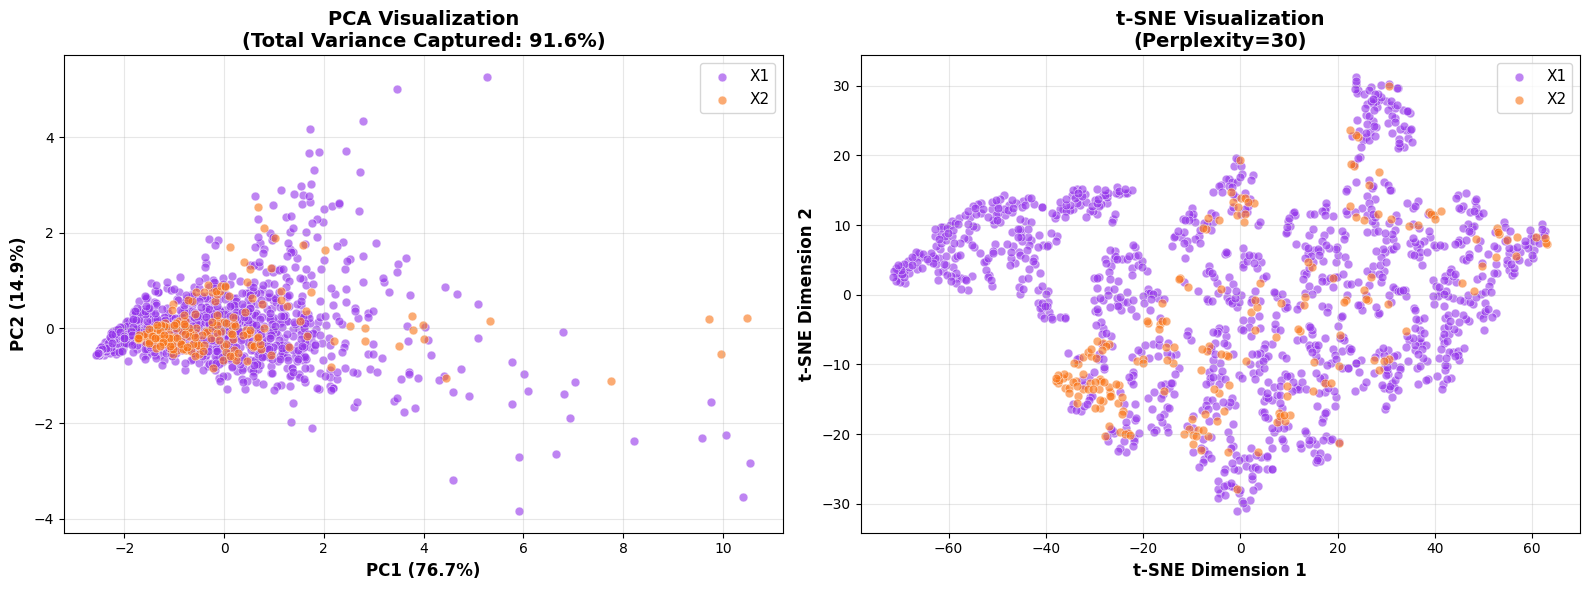

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
colors = {'X1': '#9333EA', 'X2': '#F97316'}

# ===== PCA: PC1 vs PC2 =====
ax = axes[0]
for label in ['X1', 'X2']:
    mask = labels == label
    ax.scatter(X_pca[mask, 0], X_pca[mask, 1],
               c=colors[label], label=label, alpha=0.6, s=40,
               edgecolors='white', linewidth=0.5)
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)',
              fontsize=12, fontweight='bold')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)',
              fontsize=12, fontweight='bold')

total_variance = (pca.explained_variance_ratio_[0] +
                  pca.explained_variance_ratio_[1]) * 100
ax.set_title(f'PCA Visualization\n(Total Variance Captured: {total_variance:.1f}%)',
             fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(alpha=0.3)

# ===== t-SNE =====
ax = axes[1]
for label in ['X1', 'X2']:
    mask = labels == label
    ax.scatter(X_tsne[mask, 0], X_tsne[mask, 1],
               c=colors[label], label=label, alpha=0.6, s=40,
               edgecolors='white', linewidth=0.5)
ax.set_xlabel('t-SNE Dimension 1', fontsize=12, fontweight='bold')
ax.set_ylabel('t-SNE Dimension 2', fontsize=12, fontweight='bold')
ax.set_title('t-SNE Visualization\n(Perplexity=30)',
             fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()


We can easily observe that they are very similar, but we will test using code just as a trial using euclidean distances which quantifies how far apart the two points geometrically are.

Because our PCA projection combines features into a shared space, we used to Euclidean distance to quantify the overall geometric similarity between datasets.

We do as follows:

In [76]:
# Quantify dataset independence
x1_mask = labels == 'X1'
x2_mask = labels == 'X2'

# PC1 statistics
pc1_x1_mean = X_pca[x1_mask, 0].mean()
pc1_x2_mean = X_pca[x2_mask, 0].mean()
pc1_x1_std = X_pca[x1_mask, 0].std()
pc1_x2_std = X_pca[x2_mask, 0].std()

# PC2 statistics
pc2_x1_mean = X_pca[x1_mask, 1].mean()
pc2_x2_mean = X_pca[x2_mask, 1].mean()
pc2_x1_std = X_pca[x1_mask, 1].std()
pc2_x2_std = X_pca[x2_mask, 1].std()

# Cohen's d (effect size) for PC1
pooled_std_pc1 = np.sqrt((pc1_x1_std**2 + pc1_x2_std**2) / 2)
cohens_d_pc1 = abs(pc1_x1_mean - pc1_x2_mean) / pooled_std_pc1

# Cohen's d (effect size) for PC2
pooled_std_pc2 = np.sqrt((pc2_x1_std**2 + pc2_x2_std**2) / 2)
cohens_d_pc2 = abs(pc2_x1_mean - pc2_x2_mean) / pooled_std_pc2

# Euclidean distance between dataset centroids
centroid_distance = np.sqrt((pc1_x1_mean - pc1_x2_mean)**2 + 
                            (pc2_x1_mean - pc2_x2_mean)**2)

# Combined Cohen's d
combined_cohens_d = np.sqrt(cohens_d_pc1**2 + cohens_d_pc2**2)

print("="*60)
print("DATASET INDEPENDENCE ASSESSMENT")
print("="*60)

print(f"\nPC1 Statistics:")
print(f"  X1 mean: {pc1_x1_mean:.3f} (±{pc1_x1_std:.3f})")
print(f"  X2 mean: {pc1_x2_mean:.3f} (±{pc1_x2_std:.3f})")
print(f"  Separation: {abs(pc1_x1_mean - pc1_x2_mean):.3f}")
print(f"  Cohen's d: {cohens_d_pc1:.3f}")

print(f"\nPC2 Statistics:")
print(f"  X1 mean: {pc2_x1_mean:.3f} (±{pc2_x1_std:.3f})")
print(f"  X2 mean: {pc2_x2_mean:.3f} (±{pc2_x2_std:.3f})")
print(f"  Separation: {abs(pc2_x1_mean - pc2_x2_mean):.3f}")
print(f"  Cohen's d: {cohens_d_pc2:.3f}")

print(f"\nOverall Separation Metrics:")
print(f"  Centroid Euclidean Distance: {centroid_distance:.3f}")
print(f"  Combined Cohen's d: {combined_cohens_d:.3f}")

print(f"\nInterpretation:")
if combined_cohens_d > 0.8:
    print("STRONG SEPARATION - Datasets are clearly independent")
elif combined_cohens_d > 0.5:
    print("MODERATE SEPARATION - Datasets show some differences")
else:
    print("WEAK SEPARATION - Datasets are similar")


DATASET INDEPENDENCE ASSESSMENT

PC1 Statistics:
  X1 mean: -0.000 (±1.733)
  X2 mean: 0.000 (±1.866)
  Separation: 0.000
  Cohen's d: 0.000

PC2 Statistics:
  X1 mean: -0.000 (±0.803)
  X2 mean: 0.000 (±0.536)
  Separation: 0.000
  Cohen's d: 0.000

Overall Separation Metrics:
  Centroid Euclidean Distance: 0.000
  Combined Cohen's d: 0.000

Interpretation:
WEAK SEPARATION - Datasets are similar


We can easily observe the 2 datasets almost completely overlap, with a few exceptions (outliers) the datasets are near indistinguishable when place on top of each other, which gives the idea that indeed our feature distribtuion is similar for different datasets, we now need to also test on class to see if classes are also being aggregated properly:

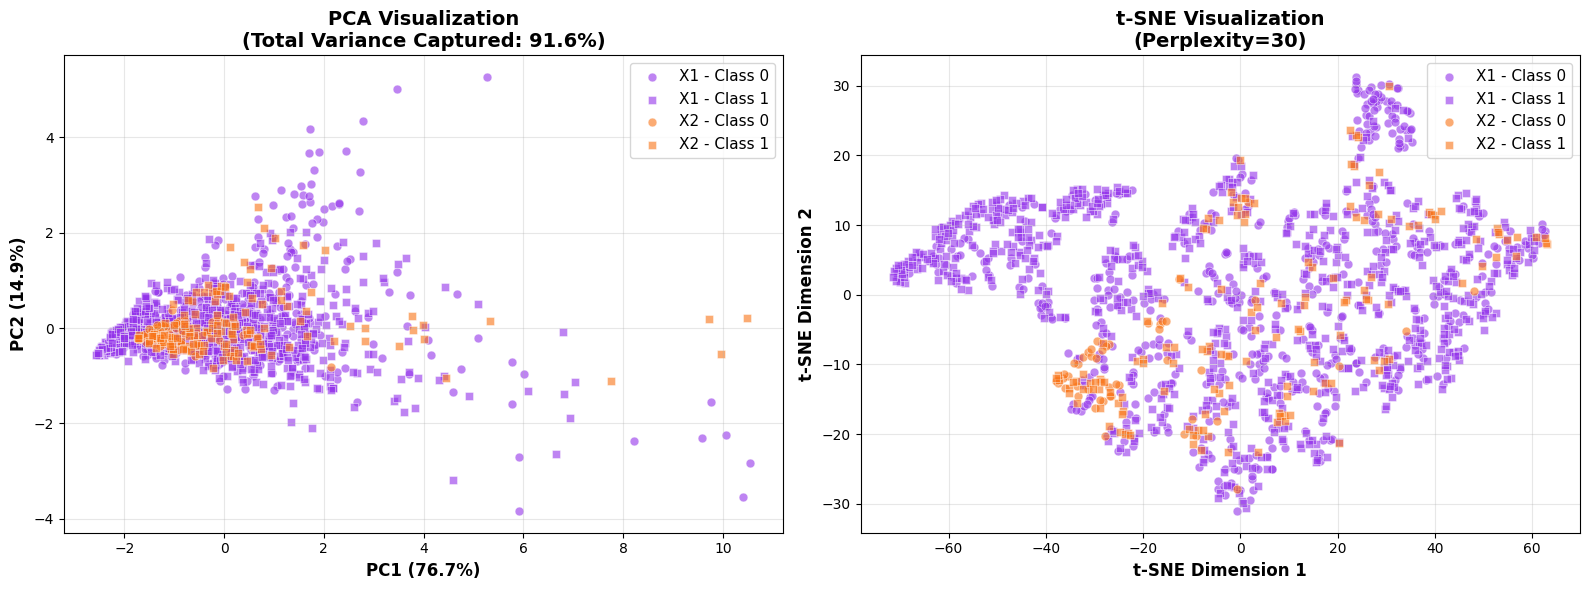

In [74]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Define colors for dataset and markers for class
dataset_colors = {'X1': '#9333EA', 'X2': '#F97316'}
class_markers = {0: 'o', 1: 's'}  # circle for class 0, square for class 1

# ===== PCA: PC1 vs PC2 =====
ax = axes[0]
for label in ['X1', 'X2']:
    for class_val in [0, 1]:
        mask = (labels == label) & (merged['Class'] == class_val)
        ax.scatter(X_pca[mask, 0], X_pca[mask, 1],
                   c=dataset_colors[label], 
                   marker=class_markers[class_val],
                   label=f'{label} - Class {class_val}', 
                   alpha=0.6, s=40,
                   edgecolors='white', linewidth=0.5)

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)',
              fontsize=12, fontweight='bold')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)',
              fontsize=12, fontweight='bold')
total_variance = (pca.explained_variance_ratio_[0] +
                  pca.explained_variance_ratio_[1]) * 100
ax.set_title(f'PCA Visualization\n(Total Variance Captured: {total_variance:.1f}%)',
             fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(alpha=0.3)

# ===== t-SNE =====
ax = axes[1]
for label in ['X1', 'X2']:
    for class_val in [0, 1]:
        mask = (labels == label) & (merged['Class'] == class_val)
        ax.scatter(X_tsne[mask, 0], X_tsne[mask, 1],
                   c=dataset_colors[label], 
                   marker=class_markers[class_val],
                   label=f'{label} - Class {class_val}', 
                   alpha=0.6, s=40,
                   edgecolors='white', linewidth=0.5)

ax.set_xlabel('t-SNE Dimension 1', fontsize=12, fontweight='bold')
ax.set_ylabel('t-SNE Dimension 2', fontsize=12, fontweight='bold')
ax.set_title('t-SNE Visualization\n(Perplexity=30)',
             fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()


We do similar to before but now with classes:

In [75]:
print("="*80)
print("CROSS-DATASET CLASS DISTANCE ANALYSIS")
print("="*80)

# Masks
x1_class0_mask = (labels == 'X1') & (merged['Class'] == 0)
x1_class1_mask = (labels == 'X1') & (merged['Class'] == 1)
x2_class0_mask = (labels == 'X2') & (merged['Class'] == 0)
x2_class1_mask = (labels == 'X2') & (merged['Class'] == 1)

# Centroids for Class 0
x1_class0_centroid_pc1 = X_pca[x1_class0_mask, 0].mean()
x1_class0_centroid_pc2 = X_pca[x1_class0_mask, 1].mean()
x2_class0_centroid_pc1 = X_pca[x2_class0_mask, 0].mean()
x2_class0_centroid_pc2 = X_pca[x2_class0_mask, 1].mean()

# Centroids for Class 1
x1_class1_centroid_pc1 = X_pca[x1_class1_mask, 0].mean()
x1_class1_centroid_pc2 = X_pca[x1_class1_mask, 1].mean()
x2_class1_centroid_pc1 = X_pca[x2_class1_mask, 0].mean()
x2_class1_centroid_pc2 = X_pca[x2_class1_mask, 1].mean()

# Euclidean distances
class0_distance = np.sqrt((x1_class0_centroid_pc1 - x2_class0_centroid_pc1)**2 + 
                          (x1_class0_centroid_pc2 - x2_class0_centroid_pc2)**2)

class1_distance = np.sqrt((x1_class1_centroid_pc1 - x2_class1_centroid_pc1)**2 + 
                          (x1_class1_centroid_pc2 - x2_class1_centroid_pc2)**2)

print(f"\nCLASS 0 - Distance between X1 and X2:")
print(f"  X1 Class 0 centroid: ({x1_class0_centroid_pc1:.3f}, {x1_class0_centroid_pc2:.3f})")
print(f"  X2 Class 0 centroid: ({x2_class0_centroid_pc1:.3f}, {x2_class0_centroid_pc2:.3f})")
print(f"  Euclidean Distance: {class0_distance:.3f}")

print(f"\nCLASS 1 - Distance between X1 and X2:")
print(f"  X1 Class 1 centroid: ({x1_class1_centroid_pc1:.3f}, {x1_class1_centroid_pc2:.3f})")
print(f"  X2 Class 1 centroid: ({x2_class1_centroid_pc1:.3f}, {x2_class1_centroid_pc2:.3f})")
print(f"  Euclidean Distance: {class1_distance:.3f}")

print(f"\n{'='*80}")
print("GENERALIZATION ASSESSMENT")
print(f"{'='*80}")

avg_distance = (class0_distance + class1_distance) / 2
print(f"\nAverage cross-dataset distance: {avg_distance:.3f}")

if class0_distance < 1.0 and class1_distance < 1.0:
    print("\nEXCELLENT: Both classes are very close across datasets")
elif class0_distance < 2.0 and class1_distance < 2.0:
    print("\nGOOD: Both classes are reasonably close across datasets")
elif class0_distance < 3.0 and class1_distance < 3.0:
    print("\nFAIR: Classes show moderate distance across datasets")
else:
    print("\nPOOR: Classes are far apart across datasets")

if abs(class0_distance - class1_distance) > 1.0:
    print(f"\nWARNING: Large difference between Class 0 ({class0_distance:.3f}) and Class 1 ({class1_distance:.3f}) distances")

CROSS-DATASET CLASS DISTANCE ANALYSIS

CLASS 0 - Distance between X1 and X2:
  X1 Class 0 centroid: (0.223, 0.137)
  X2 Class 0 centroid: (-0.954, -0.129)
  Euclidean Distance: 1.207

CLASS 1 - Distance between X1 and X2:
  X1 Class 1 centroid: (-0.169, -0.104)
  X2 Class 1 centroid: (0.312, 0.042)
  Euclidean Distance: 0.502

GENERALIZATION ASSESSMENT

Average cross-dataset distance: 0.854

GOOD: Both classes are reasonably close across datasets


We can now safely say that both datasets are similar in their common feature space, and they have similar distributions.

We can work with one dataset then generalize to the other with no problem so long other features align as well from both datasets.

We will work with these 2 sets for now, if we decide to use another dataset we will use this procedure to ensure it aligns with our datasets.